# Pre-processing the ERS error messages

In [7]:
import pandas as pd
import re
from datetime import datetime
import pytz

df = pd.read_csv('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/dataset_generation/ers_errors/tpu-failures-2023-andrei.csv')

# Extract the TPU number from the 'text' column
def extract_tpu(text):
    #match = re.search(r"tpu-[a-zA-Z0-9-]+:pc-tdq-tpu-(\d+)", text)
    match = re.search(r"pc-tdq-tpu-(\d+)", text)
    return match.group(1) if match else None

# Extract the failure source from the 'text' column
def extract_failure_source(text):
    #match = re.search(r"Component: ([^:]+):HLT", text)
    #match = re.search(r"Test failure for application: ([^:]+):HLT", text)
    match = re.search(r"Test failure for application: ([^:]+)", text)
    return match.group(1) if match else None


# Convert 'time' to Europe/Berlin timezone
def convert_to_cern_timezone(time_str):

    time_format = "%H:%M:%S %b %d %Y"
    
    # Convert the time string to a naive datetime object
    naive_dt = datetime.strptime(time_str, time_format)
    
    # Assign UTC timezone to the naive datetime (assuming the input is in UTC)
    utc_timezone = pytz.timezone('UTC')
    utc_dt = utc_timezone.localize(naive_dt)
    
    # Convert the UTC datetime to Europe/Berlin timezone
    cern_timezone = pytz.timezone('Europe/Berlin')
    cern_dt = utc_dt.astimezone(cern_timezone)
    
    return cern_dt



# Apply the functions to the DataFrame to create new columns
df['tpu_number'] = df['text'].apply(extract_tpu)
df['failure_source'] = df['text'].apply(extract_failure_source)


# Convert the 'time' column to the Europe/Berlin timezone
df['time_cern'] = df['time'].apply(convert_to_cern_timezone)

# Keep only the columns we want: 'time', 'utime', 'tpu_number', and 'failure_source'
df_processed = df[['time_cern', 'utime', 'tpu_number', 'failure_source']]

# Group by 'time', 'utime', and 'tpu_number', and concatenate 'failure_source' values
df_merged = df_processed.groupby(['time_cern', 'utime', 'tpu_number']).agg({
    'failure_source': lambda x: '; '.join(x.dropna().unique())  # Merge unique failure sources with a semicolon separator
}).reset_index()

# Save or display the merged data
df_merged.to_csv("processed_data.csv", index=False)


# Testing the h5 files for training

In [ ]:
import pandas as pd

# Load each dataset into a DataFrame
train_x_df = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_train_set_2023_x.h5')
val_x_df = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_val_set_2023_x.h5')
val_y_df = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_val_set_2023_y.h5')
test_x_df = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_test_set_2023_x.h5')
test_y_df = pd.read_hdf('/eos/user/k/kstehle/atlas-hlt-datasets/reduced_hlt_test_set_2023_y.h5')

# Display the first few rows of each DataFrame to understand their structure
print("Train X Data:")
print(train_x_df.head())

print("\nValidation X Data:")
print(val_x_df.head())

print("\nValidation Y Data:")
print(val_y_df.head())

print("\nTest X Data:")
print(test_x_df.head())

print("\nTest Y Data:")
print(test_y_df.head())


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the index is a DatetimeIndex
if not isinstance(train_x_df.index, pd.DatetimeIndex):
    train_x_df.index = pd.to_datetime(train_x_df.index)

# Check if the DatetimeIndex is timezone-naive or timezone-aware
if train_x_df.index.tz is None:
    # If timezone-naive, localize to the desired timezone
    train_x_df.index = train_x_df.index.tz_localize('Europe/Paris')
else:
    # If timezone-aware, convert to the desired timezone if necessary
    train_x_df.index = train_x_df.index.tz_convert('Europe/Paris')

# Now the index (timestamps) is ready to be used directly in plotting
timestamp = train_x_df.index

# Now the timestamp is ready to be used, and it will remain the index
train_x_df.index = timestamp  # Assign the localized/converted timestamp back to the index

# Select only the median and std columns
median_columns = [col for col in train_x_df.columns if col.startswith('m_')]
std_columns = [col for col in train_x_df.columns if col.startswith('std_')]

# Plot each median and corresponding standard deviation as a function of time
plt.figure(figsize=(14, 8))

for median_col, std_col in zip(median_columns, std_columns):
    plt.plot(timestamp, train_x_df[median_col], label=f'{median_col}')
    plt.fill_between(timestamp, 
                     train_x_df[median_col] - train_x_df[std_col], 
                     train_x_df[median_col] + train_x_df[std_col], 
                     alpha=0.2, label=f'{median_col} ± {std_col}')

plt.title('Medians and Standard Deviations Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, borderaxespad=0.)

# Set x-axis major formatter to show year, month, day, hour, minute, and second
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Optionally set major locator to improve readability (e.g., every 10 minutes)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate and format the x-axis dates for better readability
plt.gcf().autofmt_xdate()

plt.show()



# Testing the Offline detection step by step

In [ ]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np


import os
import re
from tqdm import trange

In [ ]:
rack_colors = {  0: '#D81B60',
                 1: '#1E88E5',
                 2: '#FFC107',
                 3: '#004D40',
                 4: '#C43F42',
                 5: '#6F8098',
                 6: '#D4FC14',
                 7: '#1CB2C5',
                 8: '#18F964',
                 9: '#1164B3'}

SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [ ]:
def get_tpu_number(channel_name):
    parameters = [int(substring) for substring in re.findall(r'\d+', channel_name)]
    return parameters[4]


def get_rack_hardware_configuration(rack_number: int,
                                        variant: str = '2018'):
    
    if variant == '2018':

        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (70 <= rack_number <= 77) or\
                    (79 <= rack_number <= 90):
            return 2
        elif 16 <= rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not '
                                f'in known nodes for variant {variant}')

    # need to check this and include the rest of the years
    if variant == '2023':

        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (64 <= rack_number <= 77) or\
                    (79 <= rack_number <= 90):
            return 2
        elif rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not '
                                f'in known nodes for variant {variant}')
    
    else:
        raise NotImplementedError('Rack hardware configuration '
                                    'identification not implemented '
                                    f'for variant {variant}')

# Testing the train, test and val samples for 2023

In [ ]:
#variant = "2023"
#hlt_data_pd = pd.read_csv('/eos/user/k/kstehle/atlas-hlt-datasets/test_set_dcm_rates_2023.csv', index_col=0, parse_dates=True)

#xlim_lower = 0
#xlim_upper = -1

#hlt_data_pd

In [ ]:
import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')


from reduction.medianstdreducer import MedianStdReducer
from transformer_based_detection.informers.informerrunner import InformerRunner
from utils.anomalyregistry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector

importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

In [ ]:
hlt_data_pd = pd.read_csv('/eos/user/k/kstehle/atlas-hlt-datasets/test_set_dcm_rates_2023.csv', index_col=0, parse_dates=True)

rack_config = '2023'

tpu_labels = list(hlt_data_pd.columns.values)

In [ ]:
hlt_data_pd.describe()

In [ ]:
variant = "2023"


xlim_lower = 0
xlim_upper = -1
    
    
column_names = list(hlt_data_pd.columns.values)
print(f'Channels: {len(column_names)}')

nan_amount = np.mean(np.sum(pd.isna(hlt_data_pd.to_numpy()), 1)/hlt_data_pd.shape[1])
print(f'Mean sparsity original dataset: {100*nan_amount:.3f} %')

hlt_data_pd.dropna(axis=0,
                  thresh=50,
                  inplace=True)

hlt_data_np = hlt_data_pd.to_numpy()

nan_amount = np.mean(np.sum(pd.isna(hlt_data_np), 1)/hlt_data_pd.shape[1])
print(f'Mean sparsity preprocessed: {100*nan_amount:.3f} %')


tpu_numbers = [get_tpu_number(label) for label in column_names]
tpu_numbers_unique = np.array(list(set(tpu_numbers)))
rack_numbers = np.floor_divide(tpu_numbers, 1000)

hardware_configurations =[get_rack_hardware_configuration(rack_number, variant) + 1 for rack_number in rack_numbers]

channel_colors = [rack_colors[configuration] for configuration in hardware_configurations]

xlim_lower = 0
xlim_upper = -1

fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Event Rate [Hz]')

ax.set_ylim(-1, 60)

ax.grid()

x = np.arange(len(hlt_data_np[xlim_lower:xlim_upper, :]))*5/3600

for channel in trange(hlt_data_np.shape[-1], desc='Plotting'):
    ax.plot(x, hlt_data_np[xlim_lower:xlim_upper, channel], linewidth=1, color=channel_colors[channel])

plt.tight_layout()
plt.show()

In [ ]:
m_dbscan_eps = 3
m_dbscan_min_samples = 4
m_dbscan_duration_threshold = 4

dbscan_anomaly_detector = HLTDBSCANAnomalyDetector(tpu_labels,
                                                   m_dbscan_eps,
                                                   m_dbscan_min_samples,
                                                   m_dbscan_duration_threshold)

In [ ]:
output_dir = "output"
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

dbscan_anomaly_detector.register_detection_callback(
                        json_anomaly_registry.clustering_detection)
timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [ ]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            dbscan_anomaly_detector.process(timestamp, data)            
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("test_dataset")

# Original code

In [ ]:
variant = "2023"
dataset_df = pd.read_csv('data/hlt_data_pd_2.csv', index_col=0)

xlim_lower = 0
xlim_upper = -1
    
    
column_names = list(dataset_df.columns.values)
print(f'Channels: {len(column_names)}')

nan_amount = np.mean(np.sum(pd.isna(dataset_df.to_numpy()), 1)/dataset_df.shape[1])
print(f'Mean sparsity original dataset: {100*nan_amount:.3f} %')

dataset_df.dropna(axis=0,
                  thresh=50,
                  inplace=True)

dataset_np = dataset_df.to_numpy()

nan_amount = np.mean(np.sum(pd.isna(dataset_np), 1)/dataset_df.shape[1])
print(f'Mean sparsity preprocessed: {100*nan_amount:.3f} %')


tpu_numbers = [get_tpu_number(label) for label in column_names]
tpu_numbers_unique = np.array(list(set(tpu_numbers)))
rack_numbers = np.floor_divide(tpu_numbers, 1000)

hardware_configurations =[get_rack_hardware_configuration(rack_number, variant) + 1 for rack_number in rack_numbers]

channel_colors = [rack_colors[configuration] for configuration in hardware_configurations]


In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Event Rate [Hz]')

ax.set_ylim(-1, 60)

ax.grid()

x = np.arange(len(dataset_np[xlim_lower:xlim_upper, :]))*5/3600

for channel in trange(dataset_np.shape[-1], desc='Plotting'):
    ax.plot(x, dataset_np[xlim_lower:xlim_upper, channel], linewidth=1, color=channel_colors[channel])

plt.tight_layout()
plt.show()

# Starting the model prediction

In [ ]:
#!/usr/bin/env python3

import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')


from reduction.medianstdreducer import MedianStdReducer
from transformer_based_detection.informers.informerrunner import InformerRunner
from utils.anomalyregistry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector

importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

In [ ]:
hlt_data_pd = pd.read_csv('data/hlt_data_pd_2.csv', index_col=0, parse_dates=True)

rack_config = '2023'

tpu_labels = list(hlt_data_pd.columns.values)

In [ ]:
tpu_labels

In [ ]:
hlt24_cols = [col for col in hlt_data_pd.columns if 'HLT-24' in col]
hlt28_cols = [col for col in hlt_data_pd.columns if 'HLT-28' in col]
hlt32_cols = [col for col in hlt_data_pd.columns if 'HLT-32:' in col]
hlt3232_cols = [col for col in hlt_data_pd.columns if 'HLT-32_32' in col] # 0% overallocation
hlt3240_cols = [col for col in hlt_data_pd.columns if 'HLT-32_40' in col] # 25% overallocation
hlt3248_cols = [col for col in hlt_data_pd.columns if 'HLT-32_48' in col] # 50% overallocation

In [ ]:
m_dbscan_eps = 3
m_dbscan_min_samples = 4
m_dbscan_duration_threshold = 4

dbscan_anomaly_detector = HLTDBSCANAnomalyDetector(tpu_labels,
                                                   m_dbscan_eps,
                                                   m_dbscan_min_samples,
                                                   m_dbscan_duration_threshold)

In [ ]:
output_dir = "output"
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

dbscan_anomaly_detector.register_detection_callback(
                        json_anomaly_registry.clustering_detection)
timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [ ]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            dbscan_anomaly_detector.process(timestamp, data)            
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("run_456522")

# Testing only on rack-48 as this was the one showing the anomalies
Spoiler. It was a bug, there are no anomalies there...

In [ ]:
def filter_columns(column_name):
    # Split the column name on "."
    parts = column_name.split('.')
    if "rack-48" in parts[0]:
        return True
    return False

dataset_df = pd.read_csv('data/hlt_data_pd_2.csv', index_col=0, parse_dates=True)

# Apply the filter to get the columns we want
filtered_columns = [col for col in dataset_df.columns[:] if filter_columns(col)]

filtered_df = dataset_df[filtered_columns]

#print(filtered_df.shape)
#print(filtered_df.columns)
#print(filtered_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()

# Plot each column
for column in filtered_df.columns:
    label = extract_label(column)
    ax.plot(filtered_df.index, filtered_df[column], label=label)

ax.xaxis_date()
fig.autofmt_xdate()

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import sys

# Load JSON anomaly data
with open('output/run_456522_old.json', 'r') as file: # This was the output file when there was a bug in the tpu_labels due to the overallocation % in 2023
    anomaly_data = json.load(file)

    
# Ensure the DataFrame index is timezone-aware
dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')


# Function to extract intervals for machine "48002"
def extract_intervals_for_machine(anomaly_data, machine_name):
    intervals = []
    if machine_name in anomaly_data:
        for timestamp_str, details in anomaly_data[machine_name].items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration']
            end_time = start_time + timedelta(seconds=duration)
            intervals.append((start_time, end_time))
    return intervals



# Extract intervals for machine "48002"
intervals = extract_intervals_for_machine(anomaly_data, "48002")

# Plotting the time series data
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()




# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]


# Plot each column
for column in filtered_df.columns:
    if "48002" not in column: continue
    label = extract_label(column)
    ax.plot(filtered_df.index, filtered_df[column], label=label)

ax.xaxis_date()
fig.autofmt_xdate()

# Overlay unique anomalies
for start, end in intervals:
    ax.axvspan(start, end, color='red', alpha=0.5, zorder=1)

    
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

# Now the proper version

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

with open('output/run_454322.json', 'r') as file: 
    anomaly_data = json.load(file)

dataset_df = pd.read_csv('data/hlt_data_pd_454322.csv', index_col=0, parse_dates=True)

In [ ]:
# Ensure the DataFrame index is timezone-aware
dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')  
# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        intervals[machine_name] = []

        
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals


# Extract intervals for all machines
intervals = extract_intervals_for_all_machines(anomaly_data)

# Plotting the time series data for all machines with anomalies
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Time Series Data')
ax.set_ylim(-1, 30)
ax.grid()

# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

# Initialize legend entries to keep track of added anomaly types
legend_entries = set()

# Plot each column for each machine with anomalies
for machine_id, machine_intervals in intervals.items():
    machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
    for column in machine_columns:
        label = extract_label(column)
        ax.plot(dataset_df.index, dataset_df[column], label=f'Node {label}')
        
    # Overlay unique anomalies using axvspan
    for start, end, anomaly_type in machine_intervals:
        color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
        if anomaly_type not in legend_entries:
            ax.axvspan(start, end, color=color, alpha=0.5, zorder=1, label=anomaly_type)
            legend_entries.add(anomaly_type)
        else:
            ax.axvspan(start, end, color=color, alpha=0.5, zorder=1)
            
        # Add text annotation for machine_id
        ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)

        

# Improve the formatting of the x-axis for dates
ax.xaxis_date()
fig.autofmt_xdate()

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

plt.tight_layout()
plt.show()


# Getting the plots for all the runs with anomalies

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
import os
from matplotlib.backends.backend_pdf import PdfPages

# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        machine_name = machine_name.zfill(5)  # Ensure machine ID has 5 digits
        intervals[machine_name] = []
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals

# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

# Define a color palette for different machines
colors = list(mcolors.TABLEAU_COLORS.values())

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str or tuple): Matplotlib color
    amount (float): Amount to lighten the color (0 to 1)
    
    Returns:
    tuple: Lightened color
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    white = np.array([1, 1, 1, 1])
    return tuple((1 - amount) * np.array(c) + amount * white)

def plot_run(run_number, pdf=None):
    # Load JSON anomaly data
    json_file = f'output/run_{run_number}.json'
    csv_file = f'data/hlt_data_pd_{run_number}.csv'

    if not os.path.exists(json_file) or not os.path.exists(csv_file):
        print(f"Missing files for run number {run_number}")
        return

    with open(json_file, 'r') as file: 
        anomaly_data = json.load(file)


    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    # Ensure the DataFrame index is timezone-aware
    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
    
    # Extract intervals for all machines
    intervals = extract_intervals_for_all_machines(anomaly_data)

    # Plotting the time series data for all machines with anomalies
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    ax.set_xlabel('Time')
    ax.set_ylabel('DCM rate [kHz]')
    ax.set_title(f'Time Series Data for Run {run_number}')
    ax.set_ylim(-1, 60)
    ax.grid()

    legend_entries = set()

    # Plot each column for each machine with anomalies and an extra machine
    for idx, (machine_id, machine_intervals) in enumerate(intervals.items()):
        color = colors[idx % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        # Plot the actual machine with anomalies
        for column in machine_columns:
            label = extract_label(column)
            ax.plot(dataset_df.index, dataset_df[column], label=f'Node - {label}', color=color)
        
        # Find an extra machine with the same starting number but not in the JSON file   
        machine_prefix = str(machine_id)[:2]
        possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
        if possible_extra_machines:
            extra_column = random.choice(possible_extra_machines)
            label = extract_label(extra_column)
            ax.plot(dataset_df.index, dataset_df[extra_column], label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

        # Overlay unique anomalies
        for start, end, anomaly_type in machine_intervals:
            anomaly_color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
            if anomaly_type not in legend_entries:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1, label=anomaly_type)
                legend_entries.add(anomaly_type)
            else:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1)
                
            # Add text annotation for machine_id
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()
    
    if pdf:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

def plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf=None):
    # Define the zoom window duration (e.g., 5 minutes before and after the anomaly)
    zoom_window = timedelta(minutes=5)
    
    for machine_id, machine_intervals in intervals.items():
        color = colors[hash(machine_id) % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        for start, end, anomaly_type in machine_intervals:
            fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
            ax.set_xlabel('Time')
            ax.set_ylabel('DCM rate [kHz]')
            ax.set_title(f'Zoomed Anomaly for Run {run_number} - Node {machine_id}')
            ax.set_ylim(-1, 60)
            ax.grid()
            
            zoom_start = start - zoom_window
            zoom_end = end + zoom_window
            
            # Plot the machine's data within the zoom window
            for column in machine_columns:
                label = extract_label(column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node - {label}', color=color)
            
            # Find an extra machine with the same starting number but not in the JSON file
            machine_prefix = str(machine_id)[:2]
            possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
            if possible_extra_machines:
                extra_column = random.choice(possible_extra_machines)
                label = extract_label(extra_column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, extra_column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

            # Overlay the anomaly interval
            ax.axvspan(start, end, color='red' if anomaly_type == 'ClusteringDropToZero' else 'blue', alpha=0.5, zorder=1, label=anomaly_type)
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)
            

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
            fig.autofmt_xdate()

            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

            plt.tight_layout()

            if pdf:
                pdf.savefig(fig)
                plt.close(fig)
            else:
                plt.show()



In [ ]:
run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']

# for run_number in run_numbers:
#     plot_run(run_number)
#     # Load anomaly data and dataset_df as before
#     json_file = f'output/run_{run_number}.json'
#     csv_file = f'data/hlt_data_pd_{run_number}.csv'
#     if os.path.exists(json_file) and os.path.exists(csv_file):
#         with open(json_file, 'r') as file: 
#             anomaly_data = json.load(file)
#         dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
#         dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
#         intervals = extract_intervals_for_all_machines(anomaly_data)
#         plot_zoomed_anomalies(dataset_df, intervals, run_number)
        
        
        
# Create a PDF file to save all plots
with PdfPages('anomaly_plots.pdf') as pdf:
    for run_number in run_numbers:
        plot_run(run_number, pdf)
        # Load anomaly data and dataset_df as before
        json_file = f'output/run_{run_number}.json'
        csv_file = f'data/hlt_data_pd_{run_number}.csv'
        if os.path.exists(json_file) and os.path.exists(csv_file):
            with open(json_file, 'r') as file: 
                anomaly_data = json.load(file)
            dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
            intervals = extract_intervals_for_all_machines(anomaly_data)
            plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf)


In [ ]:
run_numbers = ['456314']

for run_number in run_numbers:
    plot_run(run_number)
    # Load anomaly data and dataset_df as before
    json_file = f'output/run_{run_number}.json'
    csv_file = f'data/hlt_data_pd_{run_number}.csv'
    if os.path.exists(json_file) and os.path.exists(csv_file):
        with open(json_file, 'r') as file: 
            anomaly_data = json.load(file)
        dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
        intervals = extract_intervals_for_all_machines(anomaly_data)
        plot_zoomed_anomalies(dataset_df, intervals, run_number)

# Looking at the informer part

In [ ]:
#!/usr/bin/env python3

import importlib
import argparse
import sys
import datetime as dt
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib import tzip
from tqdm.contrib.logging import logging_redirect_tqdm

sys.path.append('/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/detection_combined/')

from utils.anomalyregistry import JSONAnomalyRegistry
from utils.reduceddatabuffer import ReducedDataBuffer
from utils.exceptions import NonCriticalPredictionException
from utils.consolesingleton import ConsoleSingleton

import clustering.dbscananomalydetector
importlib.reload(clustering.dbscananomalydetector)
from clustering.dbscananomalydetector import HLTDBSCANAnomalyDetector

import reduction.basereducer
importlib.reload(reduction.basereducer)
from reduction.basereducer import BaseReducer

import reduction.medianstdreducer
importlib.reload(reduction.basereducer)
from reduction.medianstdreducer import MedianStdReducer


import transformer_based_detection.informers.informerrunner
importlib.reload(transformer_based_detection.informers.informerrunner)
from transformer_based_detection.informers.informerrunner import InformerRunner

In [ ]:
#hlt_data_pd = pd.read_csv('data/hlt_data_pd_456522.csv', index_col=0, parse_dates=True)
hlt_data_pd = pd.read_csv('data/hlt_data_pd_455795.csv', index_col=0, parse_dates=True)
#run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']
# Ensure the DataFrame index is timezone-aware
hlt_data_pd.index = hlt_data_pd.index.tz_convert('Europe/Berlin') 

rack_config = '2023'

median_std_reducer = MedianStdReducer(rack_config)
     
informer_runner = InformerRunner('/eos/user/k/kstehle/Documents/phd/deephydra_models/hlt_2023_mse_Scale_0.8_1.0_Scale_APP_0.8_1.0_0.01_0.05_0.05_rel_size_1.0_ratio_0.25_seed_192/', device='cpu')

tpu_labels = list(hlt_data_pd.columns.values)

In [ ]:
output_dir = "output"
model = "Informer-MSE"

if model == 'Informer-SMSE':
    reduced_data_buffer = ReducedDataBuffer(size=65)
else:
    reduced_data_buffer = ReducedDataBuffer(size=17)


reduced_data_buffer.set_buffer_filled_callback(informer_runner.detect)
        
json_anomaly_registry = JSONAnomalyRegistry(output_dir)

informer_runner.register_detection_callback(
                        json_anomaly_registry.transformer_detection)

timestamps = list(hlt_data_pd.index)
hlt_data_np = hlt_data_pd.to_numpy()

In [ ]:
with logging_redirect_tqdm():
    for count, (timestamp, data) in enumerate(tzip(timestamps, hlt_data_np)):
        try:
            output_slice = median_std_reducer.reduce_numpy(tpu_labels,
                                                            timestamp,
                                                            data)
            reduced_data_buffer.push(output_slice)
        except NonCriticalPredictionException:
            break

json_anomaly_registry.write_log_file("run_455795")

In [ ]:
/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/datasets

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
import os
from matplotlib.backends.backend_pdf import PdfPages

# Function to extract intervals for all machines
def extract_intervals_for_all_machines(anomaly_data):
    intervals = {}
    for machine_name, anomalies in anomaly_data.items():
        machine_name = machine_name.zfill(5)  # Ensure machine ID has 5 digits
        intervals[machine_name] = []
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            intervals[machine_name].append((start_time, end_time, anomaly_type))
    return intervals

# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

# Define a color palette for different machines
colors = list(mcolors.TABLEAU_COLORS.values())

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str or tuple): Matplotlib color
    amount (float): Amount to lighten the color (0 to 1)
    
    Returns:
    tuple: Lightened color
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    white = np.array([1, 1, 1, 1])
    return tuple((1 - amount) * np.array(c) + amount * white)

def plot_run(run_number, pdf=None):
    # Load JSON anomaly data
    json_file = f'output/run_{run_number}.json'
    csv_file = f'data/hlt_data_pd_{run_number}.csv'

    if not os.path.exists(json_file) or not os.path.exists(csv_file):
        print(f"Missing files for run number {run_number}")
        return

    with open(json_file, 'r') as file: 
        anomaly_data = json.load(file)


    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    # Ensure the DataFrame index is timezone-aware
    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
    
    # Extract intervals for all machines
    intervals = extract_intervals_for_all_machines(anomaly_data)

    # Plotting the time series data for all machines with anomalies
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    ax.set_xlabel('Time')
    ax.set_ylabel('DCM rate [kHz]')
    ax.set_title(f'Time Series Data for Run {run_number}')
    ax.set_ylim(-1, 60)
    ax.grid()

    legend_entries = set()
    
    anomaly_color_map = {
        'ClusteringDropToZero': 'red',
        'ClusteringGeneral': 'blue',
        'TransformerBased': 'green'
    }

    # Plot each column for each machine with anomalies and an extra machine
    for idx, (machine_id, machine_intervals) in enumerate(intervals.items()):
        color = colors[idx % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        # Plot the actual machine with anomalies
        for column in machine_columns:
            label = extract_label(column)
            ax.plot(dataset_df.index, dataset_df[column], label=f'Node - {label}', color=color)
        
        # Find an extra machine with the same starting number but not in the JSON file   
        machine_prefix = str(machine_id)[:2]
        possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
        if possible_extra_machines:
            extra_column = random.choice(possible_extra_machines)
            label = extract_label(extra_column)
            ax.plot(dataset_df.index, dataset_df[extra_column], label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

        # Overlay unique anomalies
        for start, end, anomaly_type in machine_intervals:
            #anomaly_color = 'red' if anomaly_type == 'ClusteringDropToZero' else 'blue'
            anomaly_color = anomaly_color_map.get(anomaly_type, 'black') # The default is black
            if anomaly_type not in legend_entries:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1, label=anomaly_type)
                legend_entries.add(anomaly_type)
            else:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1)
                
            # Add text annotation for machine_id
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)


    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()
    
    if pdf:
        pdf.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

def plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf=None):
    # Define the zoom window duration (e.g., 5 minutes before and after the anomaly)
    zoom_window = timedelta(minutes=5)
    
    for machine_id, machine_intervals in intervals.items():
        color = colors[hash(machine_id) % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        for start, end, anomaly_type in machine_intervals:
            fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
            ax.set_xlabel('Time')
            ax.set_ylabel('DCM rate [kHz]')
            ax.set_title(f'Zoomed Anomaly for Run {run_number} - Node {machine_id}')
            ax.set_ylim(-1, 60)
            ax.grid()
            
            zoom_start = start - zoom_window
            zoom_end = end + zoom_window
            
            # Plot the machine's data within the zoom window
            for column in machine_columns:
                label = extract_label(column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node - {label}', color=color)
            
            # Find an extra machine with the same starting number but not in the JSON file
            machine_prefix = str(machine_id)[:2]
            possible_extra_machines = [col for col in dataset_df.columns if f"tpu-rack-{machine_prefix}" in col and str(machine_id) not in col]
            if possible_extra_machines:
                extra_column = random.choice(possible_extra_machines)
                label = extract_label(extra_column)
                zoomed_data = dataset_df.loc[zoom_start:zoom_end, extra_column]
                ax.plot(zoomed_data.index, zoomed_data, label=f'Node {label} (extra)', color=lighten_color(color, 0.5))

            # Overlay the anomaly interval
            ax.axvspan(start, end, color='red' if anomaly_type == 'ClusteringDropToZero' else 'blue', alpha=0.5, zorder=1, label=anomaly_type)
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)
            

            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
            fig.autofmt_xdate()

            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

            plt.tight_layout()

            if pdf:
                pdf.savefig(fig)
                plt.close(fig)
            else:
                plt.show()



In [5]:
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
from tqdm import trange  # For progress bars
import os
from matplotlib.backends.backend_pdf import PdfPages



# Rack color mapping
rack_colors = {  0: '#D81B60',
                 1: '#1E88E5',
                 2: '#FFC107',
                 3: '#004D40',
                 4: '#C43F42',
                 5: '#6F8098',
                 6: '#D4FC14',
                 7: '#1CB2C5',
                 8: '#18F964',
                 9: '#1164B3'}

# Set font sizes for plots
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Function to determine rack hardware configuration
def get_rack_hardware_configuration(rack_number: int, variant: str = '2023'):
    if variant == '2023':
        if 44 <= rack_number <= 54:
            return 0
        elif 55 <= rack_number <= 63:
            return 1
        elif (64 <= rack_number <= 77) or (79 <= rack_number <= 95):
            return 2
        elif rack_number <= 26:
            return 3
        else:
            raise ValueError(f'Rack number {rack_number} not in known nodes for variant {variant}')
    else:
        raise NotImplementedError(f'Rack hardware configuration not implemented for variant {variant}')


def extract_intervals_for_all_machines(anomaly_data):
    clustering_intervals = {}
    transformer_intervals = {}
    transformer_counter = 0
    
    for machine_name, anomalies in anomaly_data.items():
        machine_name = machine_name.zfill(5)  # Ensure machine ID has 5 digits
        
        # If there are Transformer-based anomalies, treat them separately (not associated with a machine)
        for timestamp_str, details in anomalies.items():
            start_time = pd.to_datetime(timestamp_str)
            if start_time.tzinfo is None:
                start_time = start_time.tz_localize('Europe/Berlin')
            else:
                start_time = start_time.tz_convert('Europe/Berlin')
            duration = details['duration'] * 5  # Convert timesteps to seconds (each timestep is 5 seconds)
            end_time = start_time + timedelta(seconds=duration)
            anomaly_type = details['types'][0]
            
            if anomaly_type == 'TransformerBased':
                transformer_intervals[transformer_counter] = (start_time, end_time, anomaly_type)
                transformer_counter += 1  # Increment the counter for each new anomaly

            else:
                if machine_name not in clustering_intervals:
                    clustering_intervals[machine_name] = []
                clustering_intervals[machine_name].append((start_time, end_time, anomaly_type))
                
    return clustering_intervals, transformer_intervals


# Function to extract the label from the column name
def extract_label(column_name):
    return column_name.split(':')[-1].split('.')[0].split('-')[-1]

def get_tpu_number(channel_name):
    parameters = [int(substring) for substring in re.findall(r'\d+', channel_name)]
    return parameters[4]

# Define a color palette for different machines
colors = list(mcolors.TABLEAU_COLORS.values())

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by mixing it with white.
    
    Parameters:
    color (str or tuple): Matplotlib color
    amount (float): Amount to lighten the color (0 to 1)
    
    Returns:
    tuple: Lightened color
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = mcolors.to_rgba(c)
    white = np.array([1, 1, 1, 1])
    return tuple((1 - amount) * np.array(c) + amount * white)

def plot_run(run_number, pdf=None):
    # Load JSON anomaly data
    json_file = f"/eos/user/j/jhoya/DAQ/AnomalyDetection/ML_resources/Strada_parts/results/run_{run_number}.json"
    csv_file = f"/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/datasets/csv_2023/hlt_data_pd_{run_number}.csv"

    if not os.path.exists(json_file) or not os.path.exists(csv_file):
        #print(json_file)
        #print(csv_file)
        print(f"Missing files for run number {run_number}")
        return

    with open(json_file, 'r') as file: 
        anomaly_data = json.load(file)

    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
    
    # Extract clustering and transformer-based intervals
    clustering_intervals, transformer_intervals = extract_intervals_for_all_machines(anomaly_data)
    print(f"clustering_intervals: {clustering_intervals}")
    print(f"transformer_intervals: {transformer_intervals}")

    # Plot clustering anomalies
    #plot_clustering_anomalies(run_number, dataset_df, clustering_intervals, pdf)

    # Plot transformer-based anomalies
    plot_transformer_anomalies(run_number, dataset_df, transformer_intervals, pdf)


def plot_clustering_anomalies(run_number, dataset_df, clustering_intervals, pdf=None):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
    ax.set_xlabel('Time')
    ax.set_ylabel('DCM rate [kHz]')
    ax.set_title(f'Clustering Anomalies for Run {run_number}')
    ax.set_ylim(-1, 60)
    ax.grid()

    legend_entries = set()
    
    anomaly_color_map = {
        'ClusteringDropToZero': 'red',
        'ClusteringGeneral': 'blue',
    }

    for idx, (machine_id, machine_intervals) in enumerate(clustering_intervals.items()):
        color = colors[idx % len(colors)]
        machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
        
        # Plot the actual machine with anomalies
        for column in machine_columns:
            label = extract_label(column)
            print(label)
            ax.plot(dataset_df.index, dataset_df[column], label=f'Node - {label}', color=color)
        
        # Overlay unique anomalies
        for start, end, anomaly_type in machine_intervals:
            anomaly_color = anomaly_color_map.get(anomaly_type, 'black') # Default to black
            if anomaly_type not in legend_entries:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1, label=anomaly_type)
                legend_entries.add(anomaly_type)
            else:
                ax.axvspan(start, end, color=anomaly_color, alpha=0.5, zorder=1)
                
            # Add text annotation for machine_id
            ax.text(start, ax.get_ylim()[1] - 1, f'{machine_id}', rotation=90, verticalalignment='top', fontsize=8, color=color)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()
    
    #if pdf:
    #    pdf.savefig(fig)
    #    plt.close(fig)
    #else:
    #    plt.show()
    
    plt.show()

    
    
def plot_transformer_anomalies(run_number, dataset_df, transformer_intervals, pdf=None):
    
    if not transformer_intervals:
        print("No Transformer-Based anomalies to plot.")
        return
    
    
    
    print(transformer_intervals)
    # Convert dataset to numpy for faster plotting
    dataset_np = dataset_df.to_numpy()

    # Get column names, tpu numbers, and rack numbers
    column_names = list(dataset_df.columns.values)
    tpu_numbers = [int(extract_label(label)) for label in column_names]  # Assuming get_tpu_number() is defined elsewhere
    rack_numbers = np.floor_divide(tpu_numbers, 1000)
    hardware_configurations = [get_rack_hardware_configuration(rack_number, variant='2023') for rack_number in rack_numbers]
    channel_colors = [rack_colors[config] for config in hardware_configurations]

    # Create a figure for transformer-based anomalies
    fig, ax = plt.subplots(figsize=(7, 3), dpi=300)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Event Rate [Hz]')
    ax.set_ylim(-1, 60)
    ax.grid()
    
    color = 'green'  # Use a distinct color for transformer-based anomalies
    
    
    first_timestamp = pd.to_datetime(dataset_df.index[0]).tz_convert('Europe/Berlin')

    # Create a time axis based on this first timestamp
    time_steps = len(dataset_np)
    x = [first_timestamp + pd.Timedelta(seconds=i * 5) for i in range(time_steps)]  # Each time step is 5 seconds

    # Plot each channel with the correctly aligned time axis
    for channel in trange(dataset_np.shape[-1], desc='Plotting'):
        ax.plot(x, dataset_np[:, channel], linewidth=1, color=channel_colors[channel])

#     # Loop over each machine that has transformer-based anomalies
#     for machine_id, machine_intervals in transformer_intervals.items():
#         machine_columns = [col for col in dataset_df.columns if str(machine_id) in col]
#         machine_column_indices = [column_names.index(col) for col in machine_columns]

#         # Create a time axis (assuming each timestep is 5 seconds)
#         time_steps = len(dataset_np)
#         x = np.arange(time_steps) * 5 / 3600  # Convert to hours
        
#         # Plot each column (channel) for the machine
#         for idx in machine_column_indices:
#             ax.plot(x, dataset_np[:, idx], linewidth=1, color=channel_colors[idx])

    # Overlay the anomaly intervals
    for tran_anomaly_id, (start, end, anomaly_type) in transformer_intervals.items():
        ax.axvspan(start, end, color='green', alpha=0.5, zorder=1, label=anomaly_type)
        ax.text(start, ax.get_ylim()[1] - 1, f'Anomaly {tran_anomaly_id}', rotation=90, verticalalignment='top', fontsize=8, color='green')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    fig.autofmt_xdate()

    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, borderaxespad=0.)

    plt.tight_layout()

    ## Save to PDF if provided, otherwise show plot
    #if pdf:
    #    pdf.savefig(fig)
    #    plt.close(fig)
    #else:
    #    plt.show()
    plt.show()
# Example usage
# plot_run(run_number=1)  # Replace with actual run number


clustering_intervals: {'49040': [(Timestamp('2023-06-12 23:17:50+0200', tz='Europe/Berlin'), Timestamp('2023-06-12 23:18:40+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-06-12 23:19:00+0200', tz='Europe/Berlin'), Timestamp('2023-06-12 23:20:45+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')], '76013': [(Timestamp('2023-06-13 04:29:45+0200', tz='Europe/Berlin'), Timestamp('2023-06-13 04:30:05+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '48040': [(Timestamp('2023-06-13 04:55:10+0200', tz='Europe/Berlin'), Timestamp('2023-06-13 04:55:55+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-06-13 05:02:20+0200', tz='Europe/Berlin'), Timestamp('2023-06-13 05:03:05+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')]}
transformer_intervals: {0: (Timestamp('2023-06-13 08:16:20+0200', tz='Europe/Berlin'), Timestamp('2023-06-13 11:09:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-06-13 08:16:20+0200', tz='Europe/Berlin

Plotting: 100%|██████████| 2610/2610 [04:28<00:00,  9.71it/s]


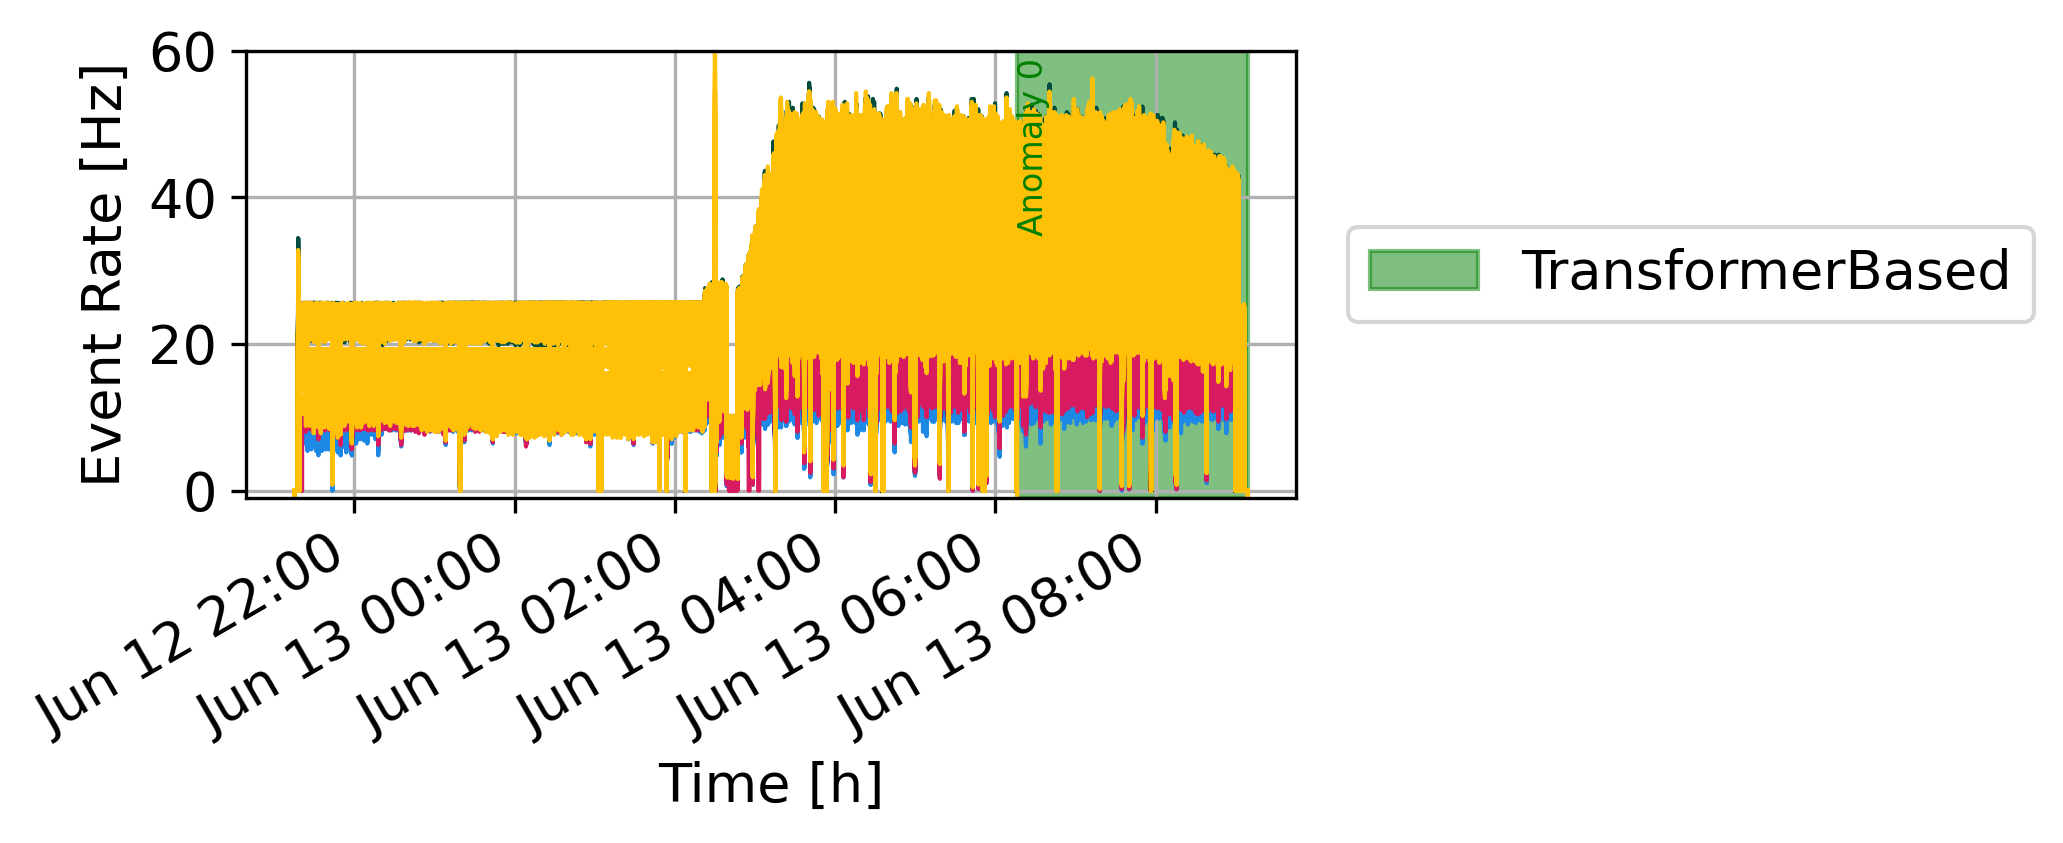

clustering_intervals: {'11023': [(Timestamp('2023-07-01 14:36:05+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 14:36:25+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '22029': [(Timestamp('2023-07-01 14:36:05+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 14:36:25+0200', tz='Europe/Berlin'), 'ClusteringGeneral')]}
transformer_intervals: {0: (Timestamp('2023-07-01 16:46:00+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 16:46:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-07-01 16:46:00+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 16:46:00+0200', tz='Europe/Berlin'), 'TransformerBased')}


Plotting: 100%|██████████| 1929/1929 [04:29<00:00,  7.16it/s]


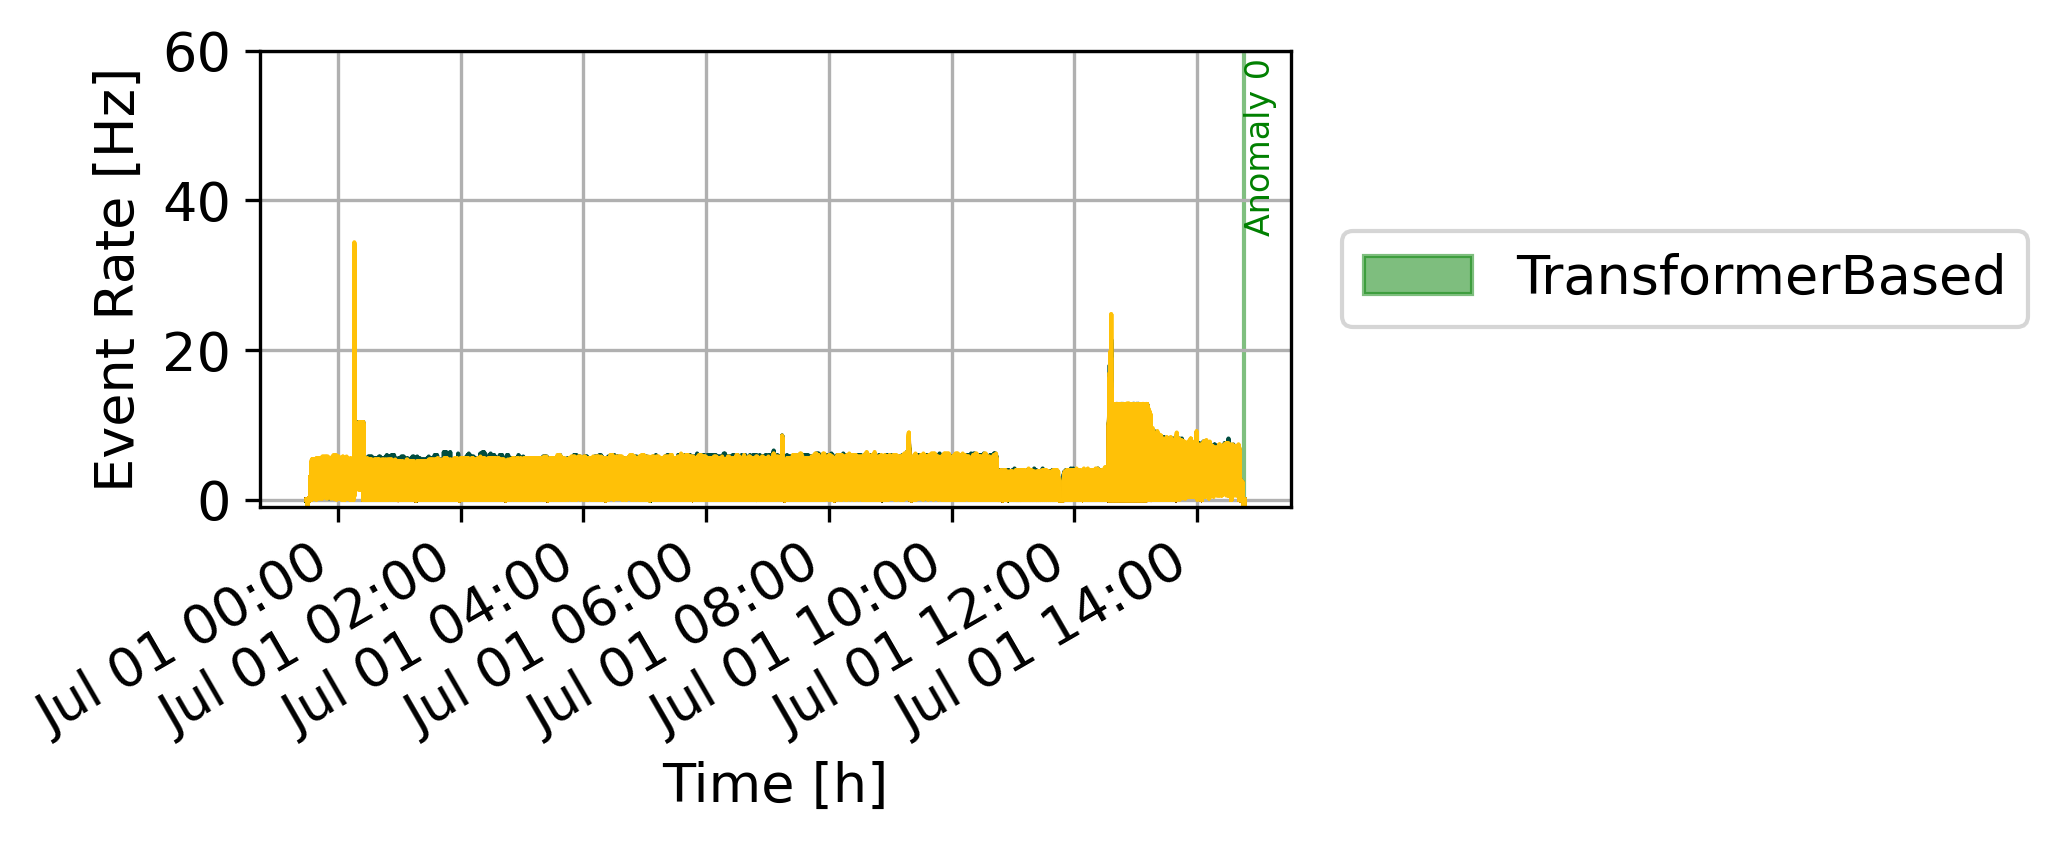

clustering_intervals: {'01026': [(Timestamp('2023-07-01 19:49:45+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:50:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '91008': [(Timestamp('2023-07-01 19:50:00+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:50:20+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '09003': [(Timestamp('2023-07-01 19:50:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:51:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '09006': [(Timestamp('2023-07-01 19:50:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:51:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '09016': [(Timestamp('2023-07-01 19:50:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:51:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '09017': [(Timestamp('2023-07-01 19:50:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-01 19:51:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '09021': [(Timestamp('2023-07-01 19:50:50+0200', tz='Europe/Berli

Plotting: 100%|██████████| 1929/1929 [01:15<00:00, 25.52it/s]


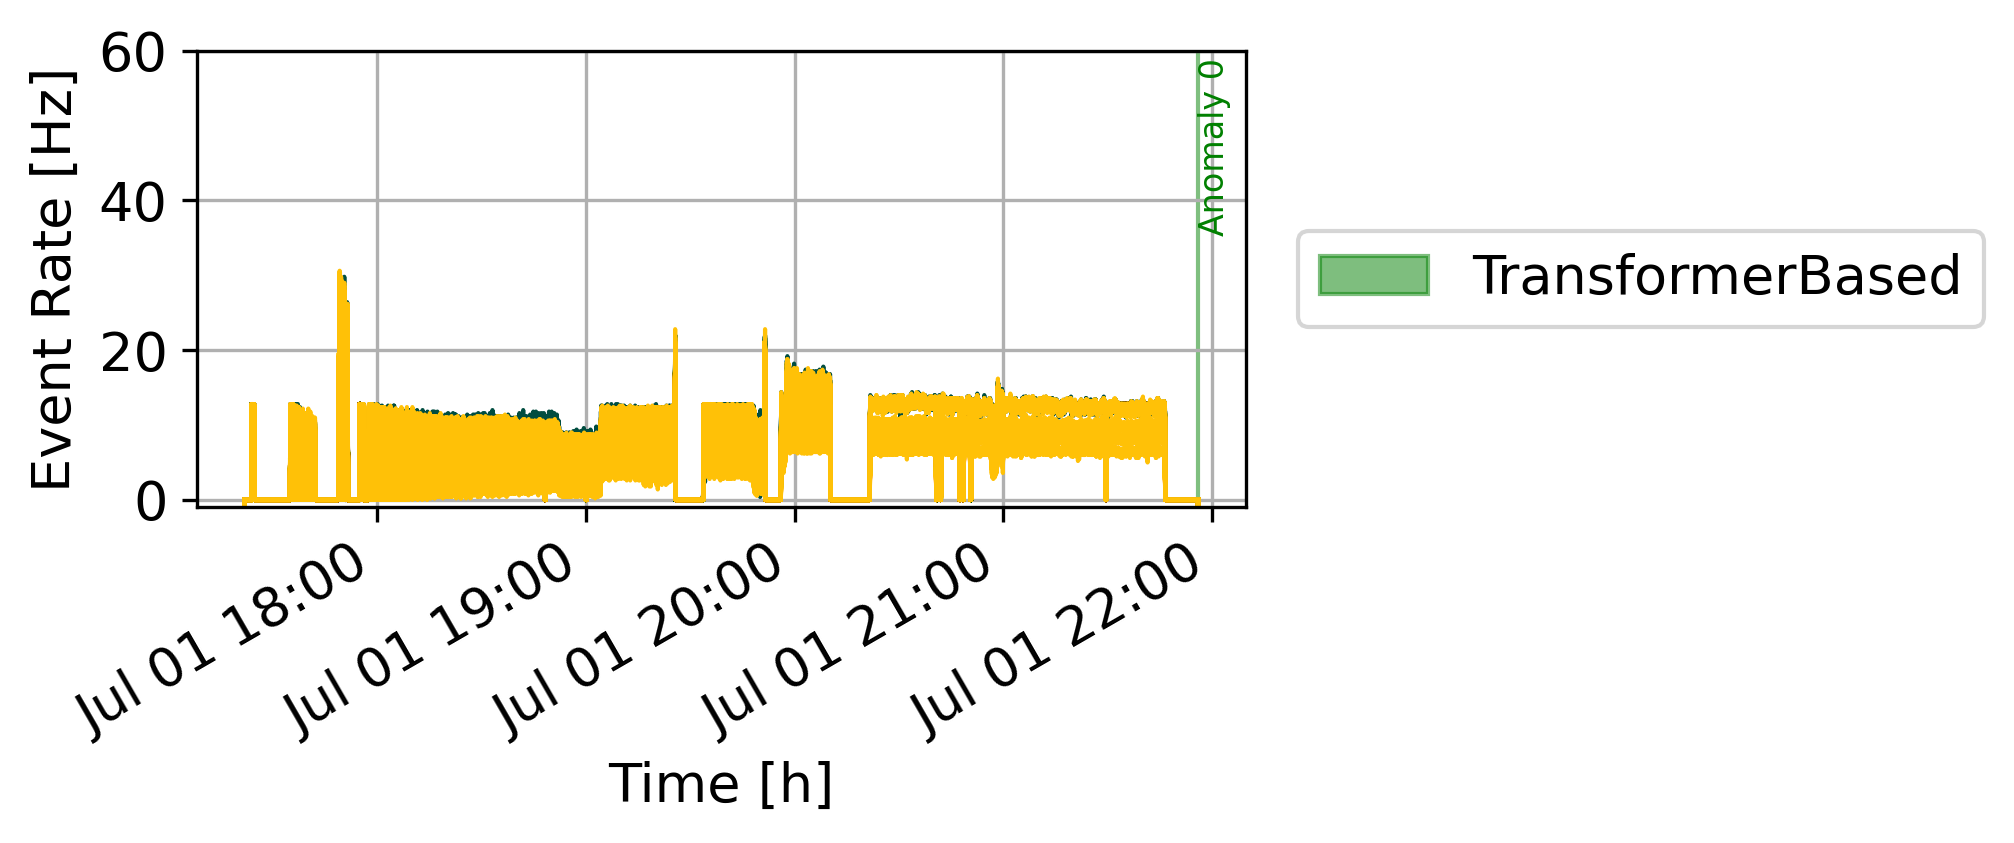

clustering_intervals: {'76019': [(Timestamp('2023-07-09 13:44:45+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 13:46:00+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-07-09 14:02:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 14:04:25+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')]}
transformer_intervals: {0: (Timestamp('2023-07-09 12:18:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 17:59:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-07-09 12:18:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 17:59:00+0200', tz='Europe/Berlin'), 'TransformerBased')}


Plotting: 100%|██████████| 2611/2611 [02:08<00:00, 20.24it/s]


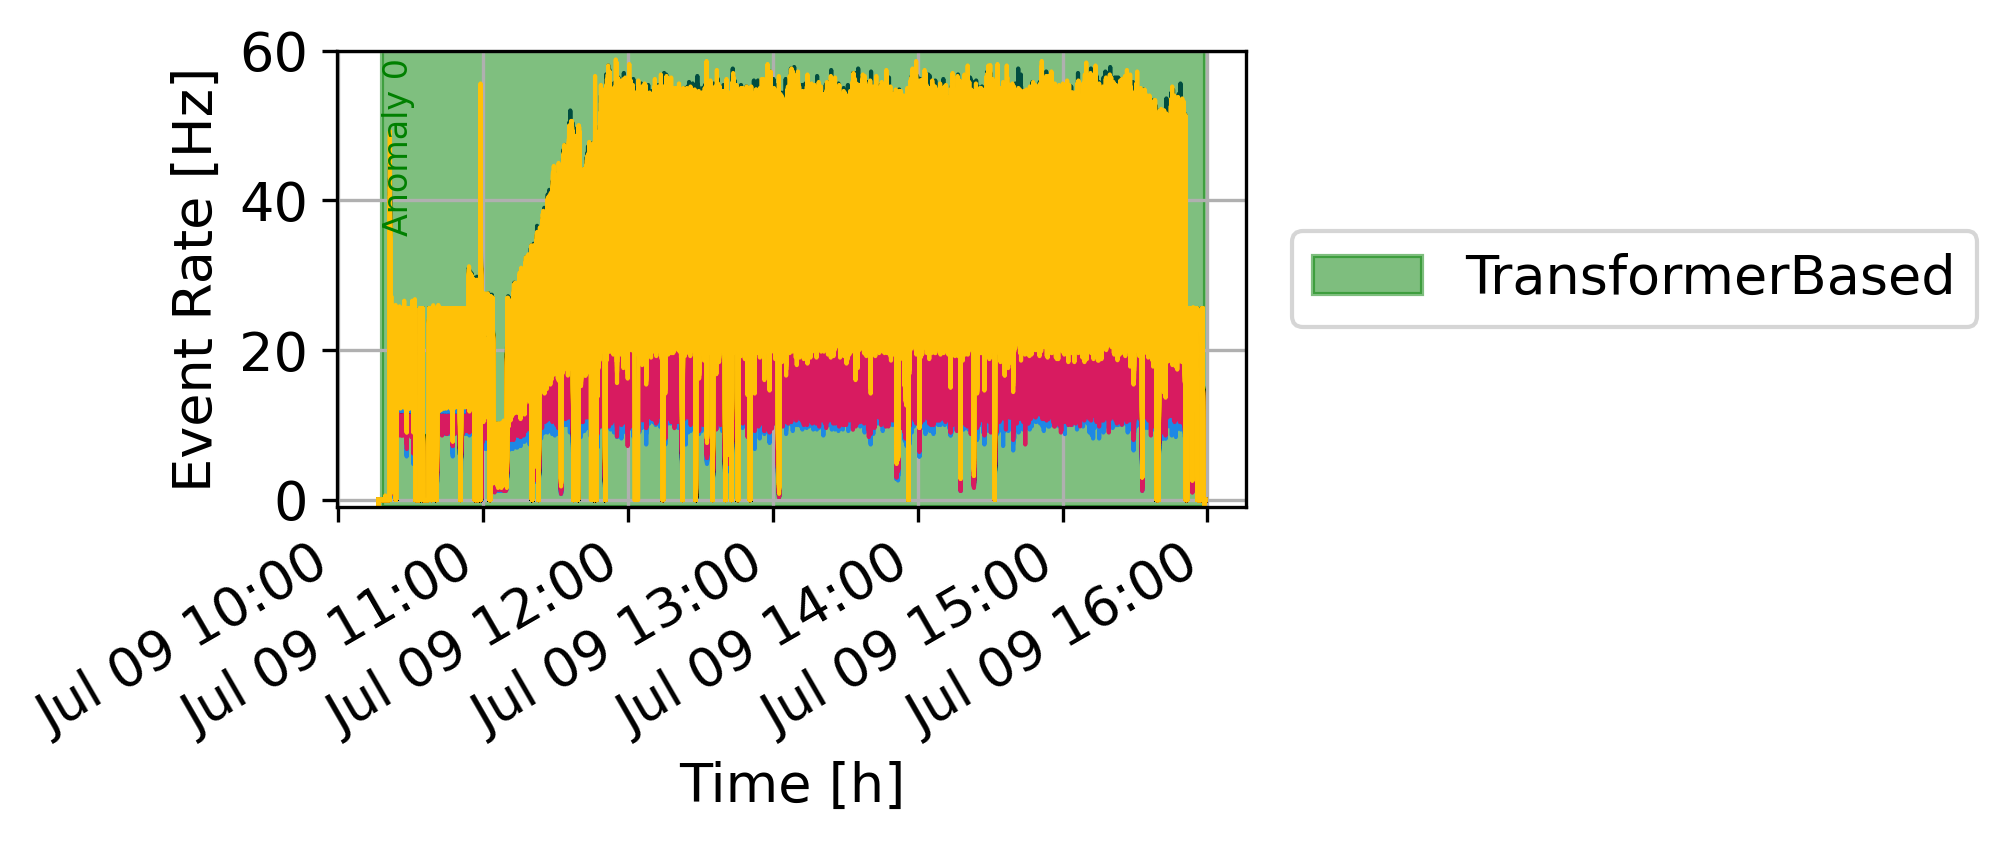

clustering_intervals: {'76019': [(Timestamp('2023-07-09 21:30:15+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 21:30:35+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-07-09 21:51:10+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 21:51:35+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-07-09 21:51:35+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 21:52:15+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-07-09 22:58:00+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 22:59:35+0200', tz='Europe/Berlin'), 'ClusteringDropToZero'), (Timestamp('2023-07-09 22:59:45+0200', tz='Europe/Berlin'), Timestamp('2023-07-09 23:00:20+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')]}
transformer_intervals: {0: (Timestamp('2023-07-09 20:04:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-10 05:44:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-07-09 20:04:20+0200', tz='Europe/Berlin'), Timestamp('2023-07

Plotting: 100%|██████████| 2611/2611 [03:45<00:00, 11.58it/s]


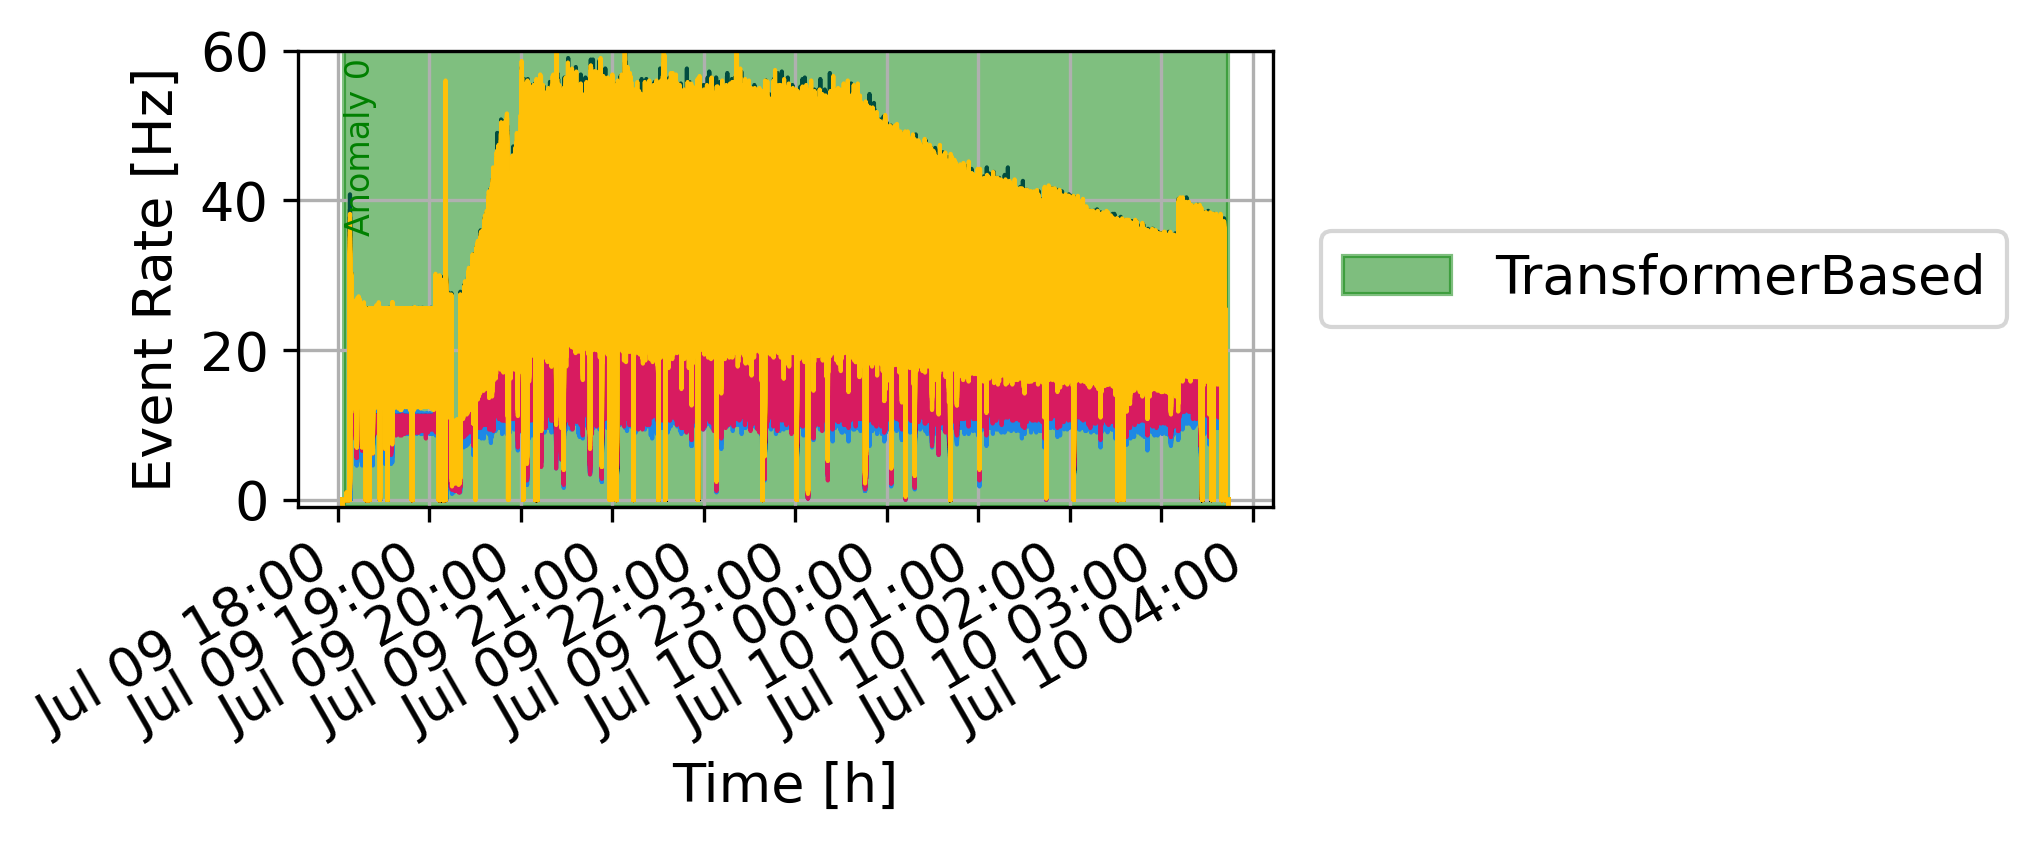

clustering_intervals: {'48040': [(Timestamp('2023-07-10 12:59:25+0200', tz='Europe/Berlin'), Timestamp('2023-07-10 13:00:05+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')], '20030': [(Timestamp('2023-07-10 16:02:25+0200', tz='Europe/Berlin'), Timestamp('2023-07-10 16:02:45+0200', tz='Europe/Berlin'), 'ClusteringGeneral')]}
transformer_intervals: {0: (Timestamp('2023-07-10 12:36:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-10 20:09:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-07-10 12:36:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-10 20:09:00+0200', tz='Europe/Berlin'), 'TransformerBased')}


Plotting: 100%|██████████| 2608/2608 [02:50<00:00, 15.28it/s]


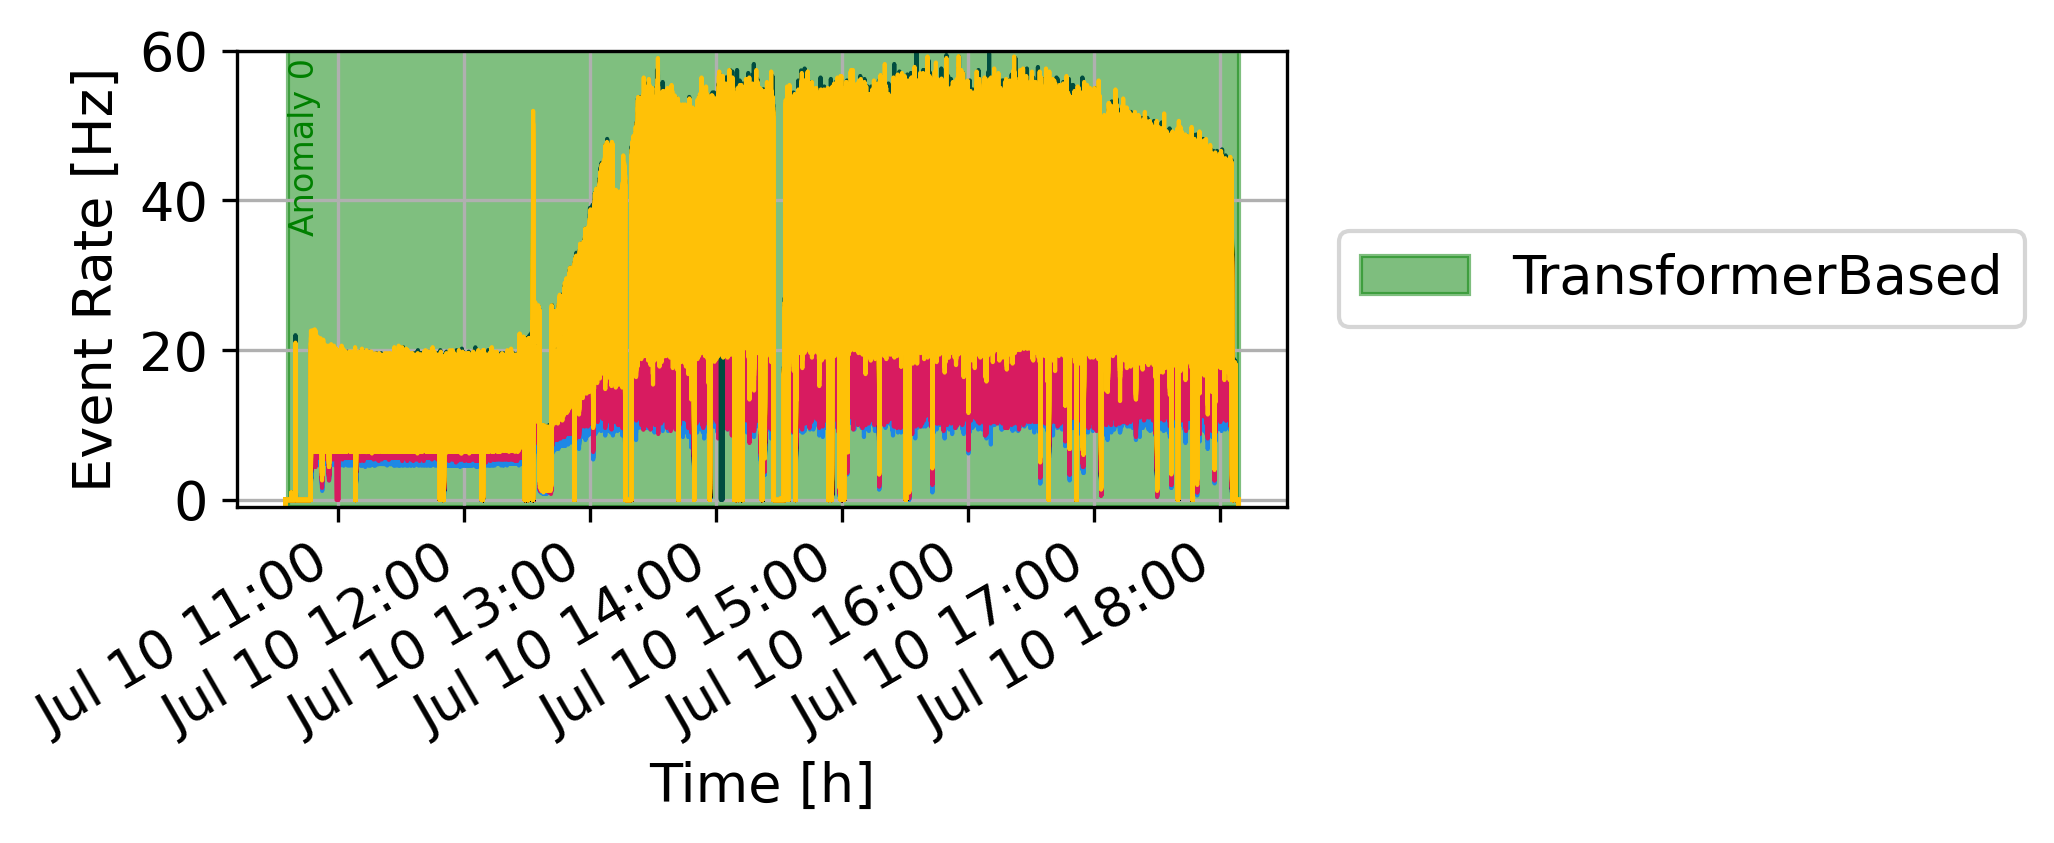

clustering_intervals: {'48040': [(Timestamp('2023-07-11 00:55:35+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 00:55:55+0200', tz='Europe/Berlin'), 'ClusteringDropToZero')]}
transformer_intervals: {0: (Timestamp('2023-07-10 23:23:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 06:24:00+0200', tz='Europe/Berlin'), 'TransformerBased')}
{0: (Timestamp('2023-07-10 23:23:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 06:24:00+0200', tz='Europe/Berlin'), 'TransformerBased')}


Plotting: 100%|██████████| 2647/2647 [02:44<00:00, 16.11it/s]


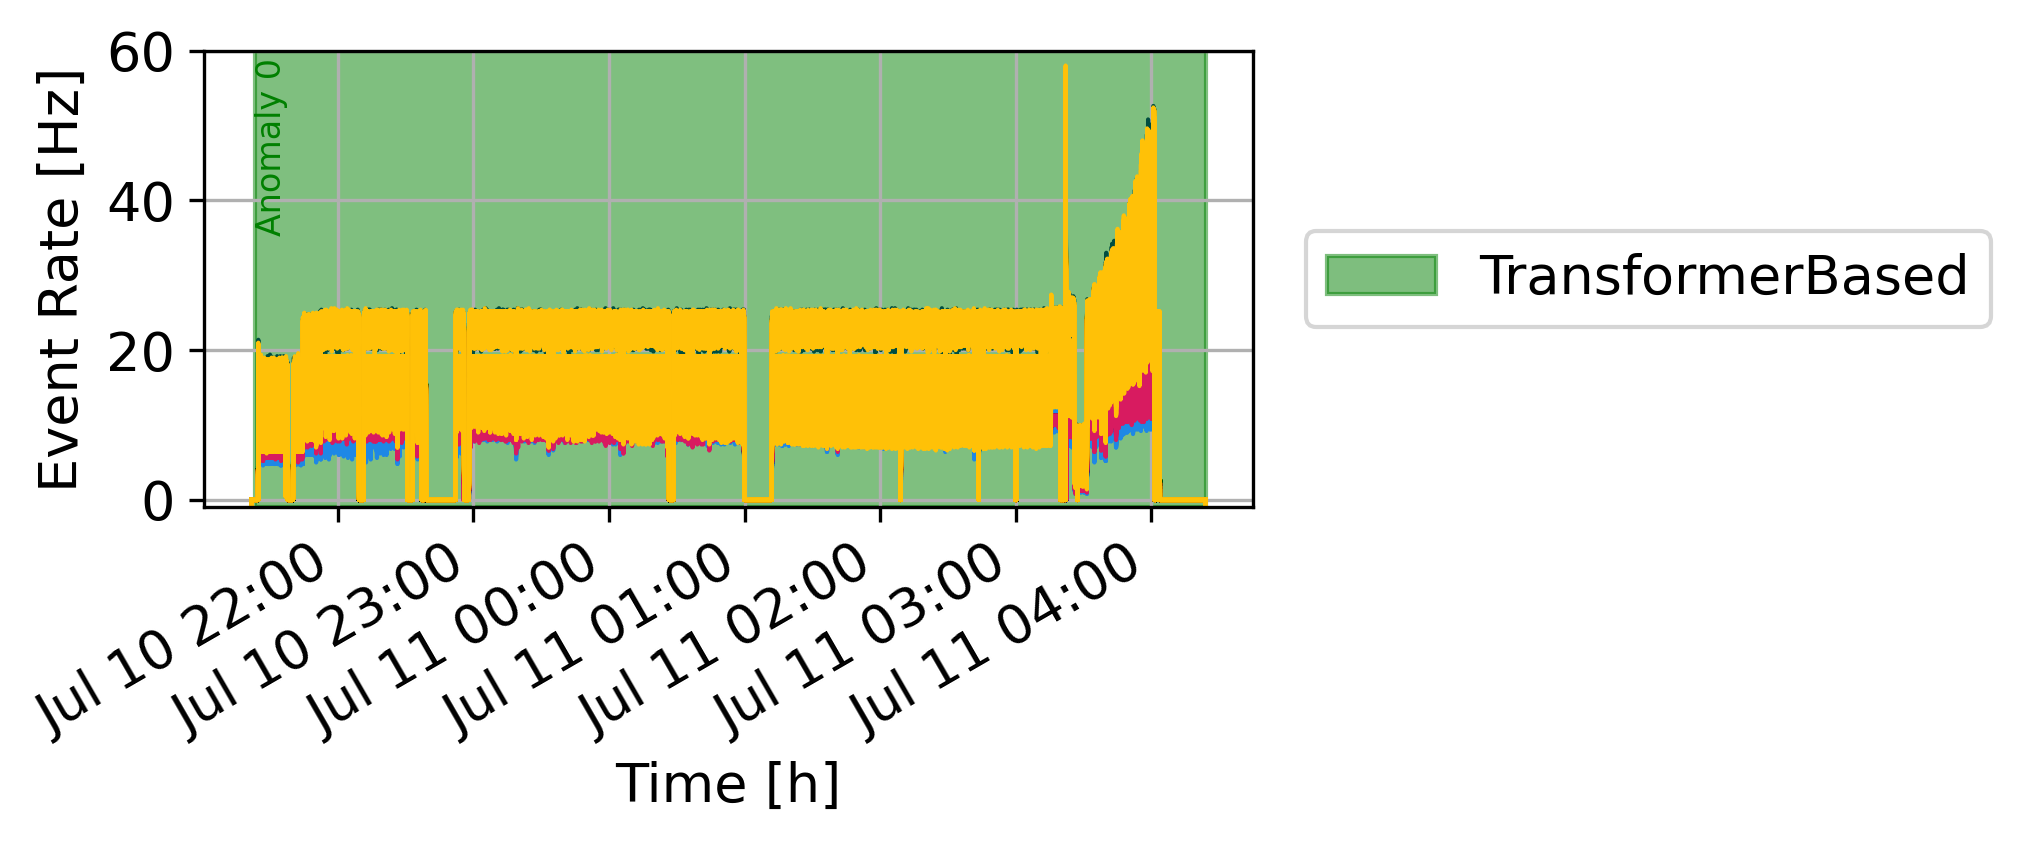

clustering_intervals: {'77035': [(Timestamp('2023-07-11 11:41:05+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 11:41:25+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '70037': [(Timestamp('2023-07-11 11:41:15+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 11:41:35+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '26026': [(Timestamp('2023-07-11 11:42:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 11:42:40+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '71040': [(Timestamp('2023-07-11 11:43:20+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 11:43:40+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '68018': [(Timestamp('2023-07-11 11:57:50+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 11:58:10+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-07-11 12:00:35+0200', tz='Europe/Berlin'), Timestamp('2023-07-11 12:00:55+0200', tz='Europe/Berlin'), 'ClusteringGeneral')], '69037': [(Timestamp('2023-07-11 11:58:20+0200', tz='Europe/Berlin'), Timest

Plotting: 100%|██████████| 2609/2609 [00:21<00:00, 123.25it/s]


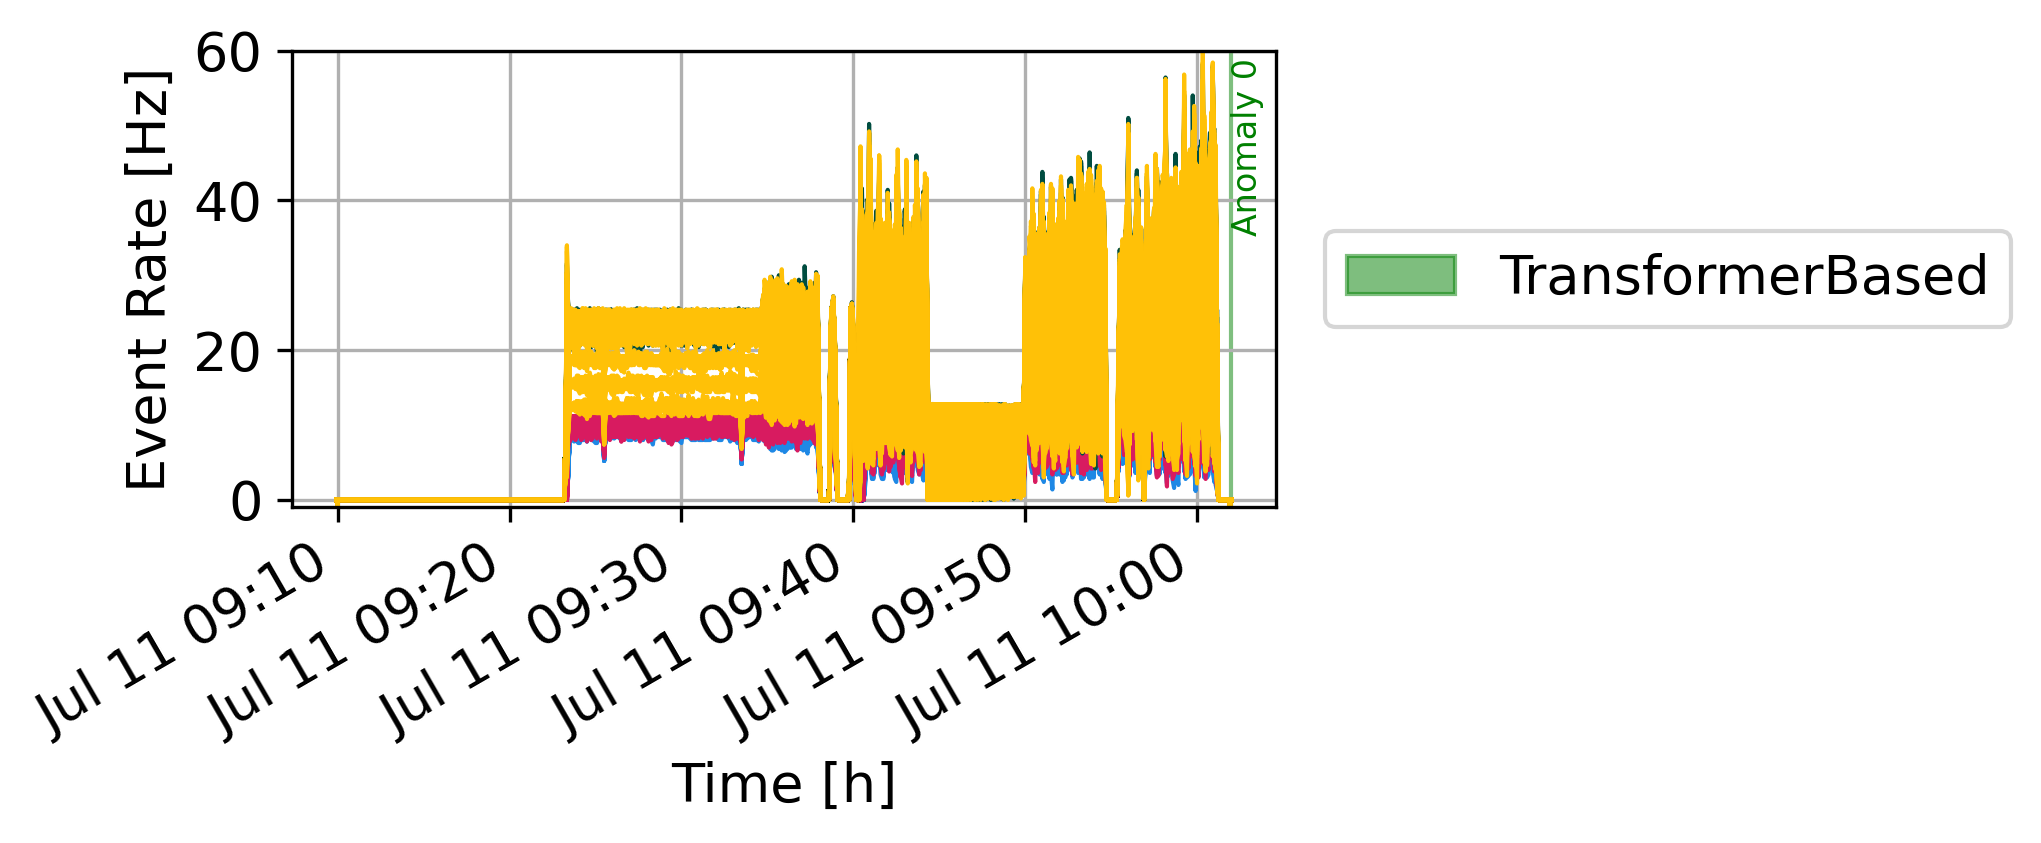

clustering_intervals: {'93029': [(Timestamp('2023-06-28 22:20:55+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 03:15:05+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 03:23:50+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 03:24:15+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 03:26:45+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 03:27:05+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 03:32:00+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 03:32:20+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 06:47:10+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 06:47:30+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 06:48:05+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 06:48:30+0200', tz='Europe/Berlin'), 'ClusteringGeneral'), (Timestamp('2023-06-29 06:49:35+0200', tz='Europe/Berlin'), Timestamp('2023-06-29 07:13:10+0200', tz='Europe/Berlin'), 'C

Plotting: 100%|██████████| 1913/1913 [07:50<00:00,  4.07it/s]


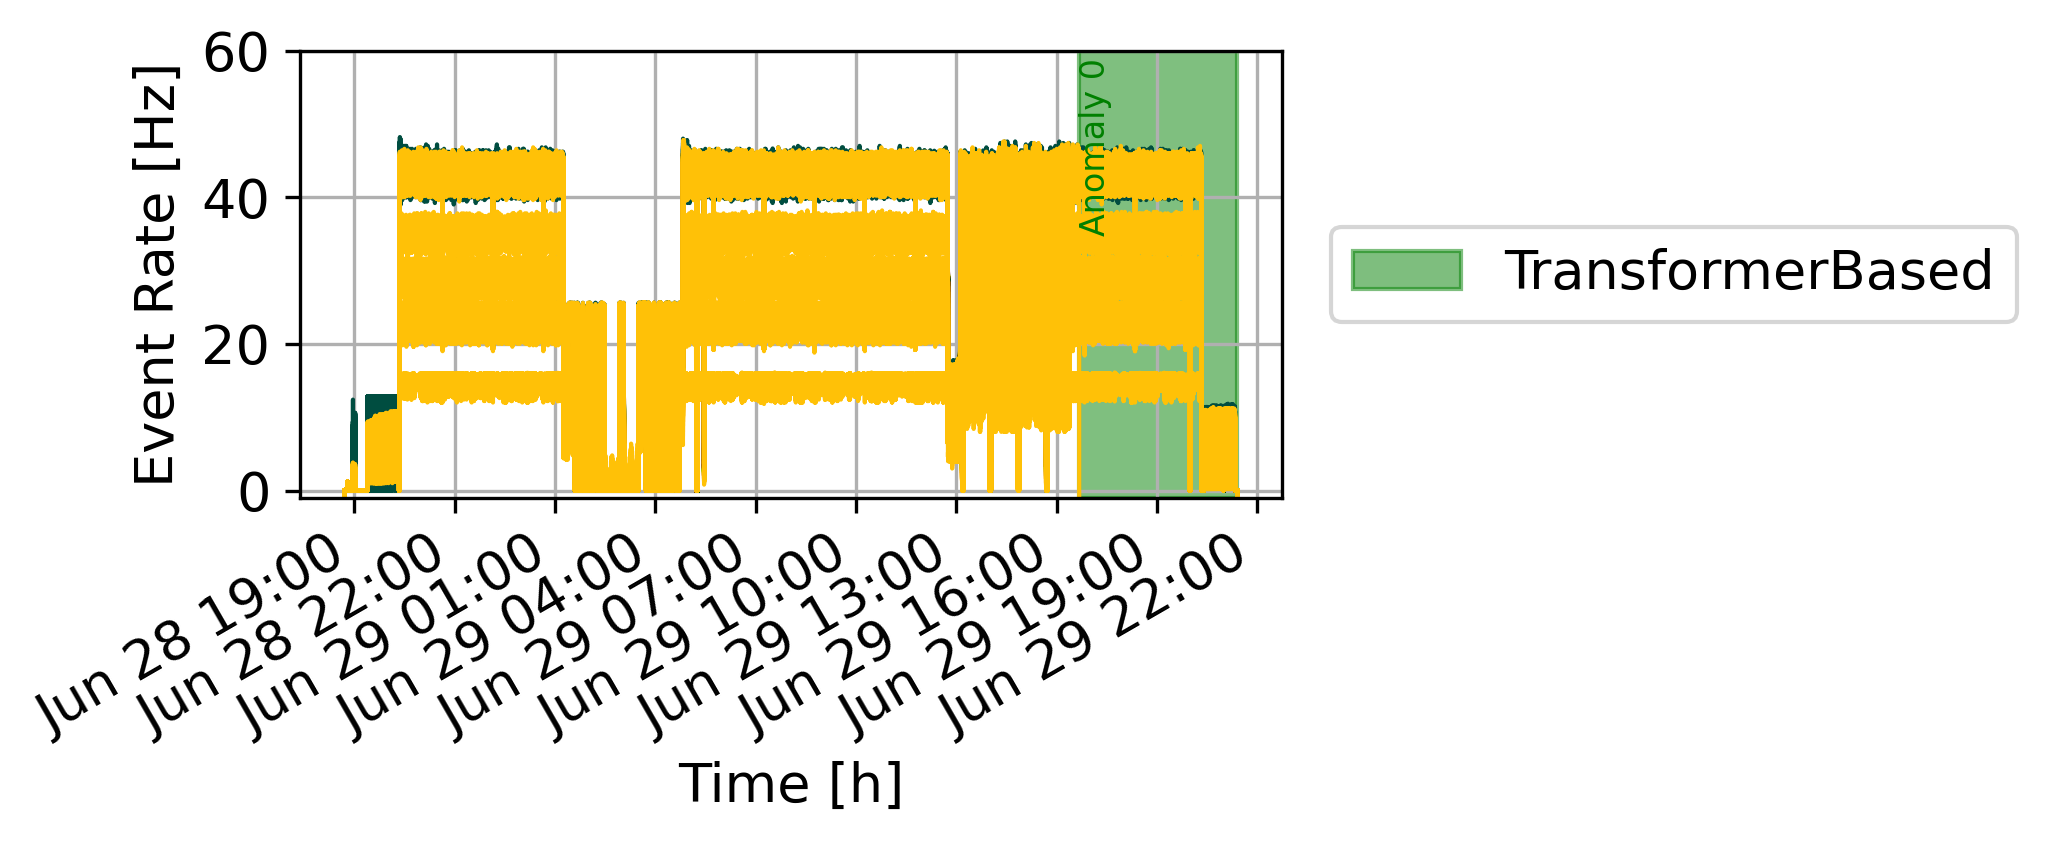

/tmp/ipykernel_685/861072464.py:21: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  plot_run(run_number, pdf)


In [6]:
run_numbers = ['454322', '455795', '455818', '456151', '456164', '456225', '456273', '456314', '455623']

# for run_number in run_numbers:
#     plot_run(run_number)
#     # Load anomaly data and dataset_df as before
#     json_file = f'output/run_{run_number}.json'
#     csv_file = f'data/hlt_data_pd_{run_number}.csv'
#     if os.path.exists(json_file) and os.path.exists(csv_file):
#         with open(json_file, 'r') as file: 
#             anomaly_data = json.load(file)
#         dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
#         dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin') 
#         intervals = extract_intervals_for_all_machines(anomaly_data)
#         plot_zoomed_anomalies(dataset_df, intervals, run_number)
        
        
        
# Create a PDF file to save all plots
with PdfPages('anomaly_plots_hybrid.pdf') as pdf:
    for run_number in run_numbers:
        plot_run(run_number, pdf)
        ## Load anomaly data and dataset_df as before
        #json_file = f'results/run_{run_number}.json'
        #csv_file = f'/eos/user/j/jhoya/DAQ/AnomalyDetection/strada/datasets/hlt_data_pd_{run_number}.csv'
        #if os.path.exists(json_file) and os.path.exists(csv_file):
        #    with open(json_file, 'r') as file: 
        #        anomaly_data = json.load(file)
        #    dataset_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        #    dataset_df.index = dataset_df.index.tz_convert('Europe/Berlin')
        #    intervals = extract_intervals_for_all_machines(anomaly_data)
        #    plot_zoomed_anomalies(dataset_df, intervals, run_number, pdf)
